In [1]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
plt.style.use('./mesa.mplstyle10')

In [2]:
def Fryer_delayed(Mco, Mfinal):
    # --------------- calculate mass of the proto NS Mproto --------------
    if Mco < 3.5:
        Mproto = 1.2
    elif Mco >= 3.5 and Mco < 6: 
        Mproto = 1.3
    elif Mco >= 6. and Mco < 11.:
        Mproto = 1.4
    else:
        Mproto = 1.6
        
    a2 = 0.133 - (0.093/(Mfinal - Mproto))
    b2 = -11*a2 + 1
    # --------------- calculate the amount of fallback onto the compact remnant ----------------    
    if Mco < 2.5:
        Mfb = 0.2
    elif Mco >= 2.5 and Mco <3.5:
        Mfb = 0.5*Mco - 1.05
    elif Mco >= 3.5 and Mco < 11:
        fb = a2*Mco + b2
        Mfb = fb*(Mfinal - Mproto)
    else:
        fb = 1.
        Mfb = fb*(Mfinal - Mproto)

    # -------------- calculate the final baryonic mass of the compact remnant --------------------
    Mrem_b = Mproto + Mfb
    
    return 0.9*Mrem_b   #returns the gravitational mass of the BH

In [3]:
# ------- Meaning of the keys --------
# spt3 := s = 0.3
# spt8 := s = 0.8
# eta_pt5 := eta = 0.5 (this determines the fraction of material lost in cocoon during explosion)
# alpha_pt1 := alpha = 0.1
dirs = ['spt3', 'spt8', 'eta_5', 'eta_2pt5', 'alpha_pt1']
subdirs = ['MAD', 'NTD', 'Nonrel_MAD', 'Nonrel_NTD']

for d in dirs:
    for sd in subdirs:
        file = f'./data/{d}/{sd}/'
        symlink = [150, 300, 450, 600, 750, 911]#, 1100, 1250, 1439]
        cols = ['Mexp', 'AMexp', 'Mbh', 'abh', 'Rexp']
        out_data = []

        df_0 = pd.read_csv(file + f'Run_data_{symlink[0]}.txt', delim_whitespace = True)
        for Z in range(len(symlink) - 1):
            df_1 = pd.read_csv(file + f'Run_data_{symlink[Z+1]}.txt',  delim_whitespace = True)
        #     out_data.append(df['Mexp'].values, )
            df_0 = pd.concat([df_0, df_1], axis=0, ignore_index=True)

        df_0.to_csv(f'./data/{d}/{sd}/concatenated_file_{sd}.csv', index=False)
        

In [4]:
# -------------- These are for the fiducial values --------------
d = 'fiducial'
dataMAD_fiducial = pd.read_csv(f'./data/{d}/MAD/concatenated_file_MAD.csv')
dataNT_fiducial = pd.read_csv(f'./data/{d}/NTD/concatenated_file_NTD.csv')
datanonrel_MAD_fiducial = pd.read_csv(f'./data/{d}/Nonrel_MAD/concatenated_file_Nonrel_MAD.csv')
datanonrel_NT_fiducial = pd.read_csv(f'./data/{d}/Nonrel_NTD/concatenated_file_Nonrel_NTD.csv')

# ----------------- Choose the one you wish to compare with the fiducial case -------------
d = 'eta_2pt5'
dataMAD = pd.read_csv(f'./data/{d}/MAD/concatenated_file_MAD.csv')
dataNT = pd.read_csv(f'./data/{d}/NTD/concatenated_file_NTD.csv')
datanonrel_MAD = pd.read_csv(f'./data/{d}/Nonrel_MAD/concatenated_file_Nonrel_MAD.csv')
datanonrel_NT = pd.read_csv(f'./data/{d}/Nonrel_NTD/concatenated_file_Nonrel_NTD.csv')
dataMAD.head(2)

,Mbh,abh,AMexp,Mexp,filename,tff,Md,Mco,Rexp,MHe_form,...,MHe_dep,AMfinal_He_dep,R_He_dep,Omega_mean_He_dep,Omega_mean_exp,Mc12_dep,AM_c12_dep,R_c12_dep,Omega_c12_dep,Eacc
0,4.984,0.1515,3.256000e+49,4.984222,0/LOGS/profile72,970.882882,5.075000e-09,2.970036,1.400817,4.999526,...,4.989663,3.300000e+49,1.453448,0.000259,0.000877,4.984223,3.256000e+49,1.453448,0.000259,8.580000e+47
1,8.938,0.1120,7.782000e+49,8.938068,2/LOGS/profile35,0.000000,0.000000e+00,6.534862,1.206268,8.998252,...,8.955658,7.956000e+49,1.206268,0.000181,0.000785,8.938069,7.782000e+49,1.206268,0.000181,0.000000e+00


### Plotting

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

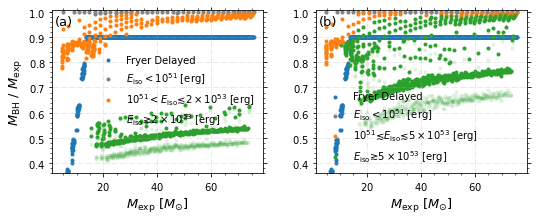

In [9]:
plt.figure(figsize = (8.5,3))
gs = GridSpec(1, 2, wspace = 0.25)

plt.subplot(gs[0])
coef = 0.01/0.05
### fractional change
MBH_Fryer = []
for i in range(len(dataNT)):
    MBH = Fryer_delayed(dataNT.loc[i,'Mco'], dataNT.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
    
plt.scatter(dataNT['Mexp'], MBH_Fryer/ dataNT['Mexp'])#, z='Mbh')

mask = coef*dataNT['Eacc'] <=1e51
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'], color = 'grey')#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*dataNT['Eacc'] > 1e51) & (coef*dataNT['Eacc'] < 2e53)
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*dataNT['Eacc']  >= 2e53
plt.scatter(dataNT[mask]['Mexp'], dataNT[mask]['Mbh'] / dataNT[mask]['Mexp'])#, z='Mbh')
 
    
# ------------------ for the fiducial values -------------------
mask = coef*dataNT_fiducial['Eacc'] <=1e51
plt.scatter(dataNT_fiducial[mask]['Mexp'], dataNT_fiducial[mask]['Mbh'] / dataNT_fiducial[mask]['Mexp'],\
            color = 'grey', alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*dataNT_fiducial['Eacc'] > 1e51) & (coef*dataNT_fiducial['Eacc'] < 2e53)
plt.scatter(dataNT_fiducial[mask]['Mexp'], dataNT_fiducial[mask]['Mbh'] / dataNT_fiducial[mask]['Mexp'],\
            color = colors[1], alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*dataNT_fiducial['Eacc']  >= 2e53
plt.scatter(dataNT_fiducial[mask]['Mexp'], dataNT_fiducial[mask]['Mbh'] / dataNT_fiducial[mask]['Mexp'],\
            color = colors[2], alpha = 0.1)#, z='Mbh')
# --------------------- End ---------------------------------------

 
plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} < E_{\\rm iso} \\lesssim 2 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ [erg]'], fontsize = 10)#, bbox_to_anchor=(0.249, 0.2, 0.5, 0.5))

# plt.title('NT accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
plt.ylim(0.36,1.01)
plt.grid(linestyle = '-.', alpha =.35)
plt.text(2, 0.95, '(a)')


# ------------------------     MAD      --------------------------

plt.subplot(gs[1])
coef = 1/0.05
### fractional change
MBH_Fryer = []
for i in range(len(dataMAD)):
    MBH = Fryer_delayed(dataMAD.loc[i,'Mco'], dataMAD.loc[i,'Mexp'])
    MBH_Fryer.append(MBH)
    
plt.scatter(dataMAD['Mexp'], MBH_Fryer/ dataMAD['Mexp'])#, z='Mbh')

mask = coef*dataMAD['Eacc'] <=1e51
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'], color = 'grey')#, z='Mbh')

# mask = dataMAD["abh"] >= .075
mask = (coef*dataMAD['Eacc'] > 1e51) & (coef*dataMAD['Eacc'] <= 5e53)
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')

# mask = dataMAD["abh"] <=.02
mask = coef*dataMAD['Eacc']  > 5e53
plt.scatter(dataMAD[mask]['Mexp'], dataMAD[mask]['Mbh'] / dataMAD[mask]['Mexp'])#, z='Mbh')
 
# ------------------ for the fiducial values -------------------
mask = coef*dataMAD_fiducial['Eacc'] <=1e51
plt.scatter(dataMAD_fiducial[mask]['Mexp'], dataMAD_fiducial[mask]['Mbh'] / dataMAD_fiducial[mask]['Mexp'],\
            color = 'grey', alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >= .075
mask = (coef*dataMAD_fiducial['Eacc'] > 1e51) & (coef*dataMAD_fiducial['Eacc'] < 5e53)
plt.scatter(dataMAD_fiducial[mask]['Mexp'], dataMAD_fiducial[mask]['Mbh'] / dataMAD_fiducial[mask]['Mexp'],\
            color = colors[1], alpha = 0.1)#, z='Mbh')

# mask = dataNT["abh"] >=.9
mask = coef*dataMAD_fiducial['Eacc']  >= 5e53
plt.scatter(dataMAD_fiducial[mask]['Mexp'], dataMAD_fiducial[mask]['Mbh'] / dataMAD_fiducial[mask]['Mexp'],\
            color = colors[2], alpha = 0.1)#, z='Mbh')
# --------------------- End ---------------------------------------
 

plt.legend(['Fryer Delayed', '$E_{\\rm iso} <  10^{51}$ [erg]', '$10^{51} \\lesssim E_{\\rm iso} \\lesssim 5 \\times 10^{53}$ [erg]', \
            '$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ [erg]'], fontsize = 10)
# plt.title('MA accretion flow', pad = 10)
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}]$')
# plt.ylabel('$M_{\\rm BH}$ / $M_{\\rm exp}$')
# plt.xlim(1,68)
plt.ylim(0.36,1.01)
plt.text(2, 0.95, '(b)')
plt.grid(linestyle = '-.', alpha =.35)

# plt.savefig('./figures/Mexp_MBH_ratio_spt3.png')
# plt.savefig('./figures/Mexp_MBH_ratio_spt8.png')
# plt.savefig('./figures/Mexp_MBH_ratio_eta_pt5.png')
# plt.savefig('./figures/Mexp_MBH_ratio_eta_2pt5.png')
# plt.savefig('./figures/Mexp_MBH_ratio_alpha_pt1.png')


In [7]:
def transform_spin(x, y):
    df = pd.DataFrame()
    
    df["x"] = x
    df["y"] = y
    
    df["sqrt(xy)"] = np.sqrt(df['x'] * df['y'])
    df["sqrt(x)"] = np.sqrt(df['x'])
    df["sqrt(y)"] = np.sqrt(df['y'])

    df["sqrt(x)x"] = np.sqrt(df['x']) * df['x']
    df["sqrt(y)x"] = np.sqrt(df['y'])  * df['x']

    df["sqrt(x)y"] = np.sqrt(df['x'])  * df['y']
    df["sqrt(y)y"] = np.sqrt(df['y'])  * df['y']
    df["square(x)"] = df['x'] * df['x']
    df["square(y)"] = df['y'] * df['y']

    df["xy"] = df['x'] * df['y']
    df["xxy"] = df['x'] * df['x'] * df['y']
    df["xyy"] = df['x'] * df['y'] * df['y']
    
    features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]

    return df[features]

Max abh for MAD eta_2pt5 =  0.5986
Max abh for MAD fiducial =  0.6006


Text(10, 1.9e+17, 'rapid  $\\longrightarrow$ \nspindown')

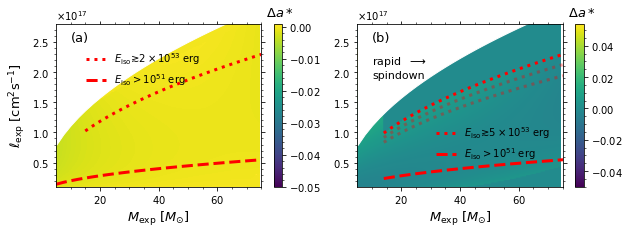

In [8]:
plt.figure(figsize = (10,3))
gs = GridSpec(1, 2, wspace = 0.175)
x = "Mexp"
y = "AMexp"
z = "abh"
msun = 1.989e33
features = ["sqrt(xy)", "sqrt(x)", "sqrt(y)", "xy", "x", "y"]
result = []

# Plot 1 
plt.subplot(gs[0])

mask = dataNT['abh'] < 1
df_temp = dataNT[mask].copy()
df_temp[y] = (dataNT['AMexp'] / dataNT['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-3
    Z1[i][Z1[i] > 0.9994] = 0.9994 #0.9994 #0.9846
    y_temp = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 15.)] = 0.9994 #0.9846
    
result.append(list(zip(features,model_linear.coef_)))
 
# -------------- For the fiducial case ----------------
mask = dataNT_fiducial['abh'] < 1
df_temp = dataNT_fiducial[mask].copy()
df_temp[y] = (dataNT_fiducial['AMexp'] / dataNT_fiducial['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataNT_fiducial[y]/ dataNT_fiducial['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])
Z1_fiducial = np.zeros(X.shape)
for i in range(len(Z1_fiducial)):
    Z1_fiducial[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1_fiducial[i][Z1_fiducial[i] < 0] = 1e-3
    Z1_fiducial[i][Z1_fiducial[i] > 0.9994] = 0.9994
    y_temp = (1.25e33*X[:, i])**(1/2)  / 1e14
    Z1_fiducial[i][(Y[:, i] > y_temp) & (X[:,i] >= 15.)] = 0.9994
# ---------------------------- End ------------------------------------
    
Z1 = Z1_fiducial - Z1
# Z1 = np.round(Z1,3)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataNT[y]/ dataNT['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))

vmin = np.min(Z1)
vmax = np.max(Z1)

y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto', vmin=-0.05, vmax=vmax)#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\,\\Delta a*$', pad = 7)
  
x_ = np.arange(15,80,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')

x_ = np.arange(5,80,2.5)
y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

plt.text(10, 2.5e17, '(a)')
plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm cm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 2 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                      bbox_to_anchor=[0.75, 0.72], loc = 'center right', fontsize=10)
# plt.yscale('log')
# plt.title('NT accretion flow')
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
# plt.xscale('log')



# ---------------------------------  MAD ----------------------------

plt.subplot(gs[1])

mask = dataMAD['abh'] > 0.12
df_temp = dataMAD[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

print(f'Max abh for MAD {d} = ', max(dataMAD['abh']))
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z1 = np.zeros(X.shape)
for i in range(len(Z1)):
    Z1[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1[i][Z1[i] < 0] = 1e-5
    Z1[i][Z1[i] > max(dataMAD['abh'])] = max(dataMAD['abh'])
    y_temp = (7e32*X[:, i])**(1/2)  / 1e14
    Z1[i][(Y[:, i] > y_temp) & (X[:,i] >= 14.)] = 0.12

result.append(list(zip(features,model_linear.coef_)))
   
# ----------------------- Fiducial bit ----------------------
mask = dataMAD_fiducial['abh'] > 0.12
df_temp = dataMAD_fiducial[mask].copy()
df_temp[y] = (df_temp['AMexp'] / df_temp['Mexp'] / msun / 1e14).astype(float)

df_temp["sqrt(xy)"] = np.sqrt(df_temp[x] * df_temp[y])
df_temp["sqrt(x)"] = np.sqrt(df_temp[x])
df_temp["sqrt(y)"] = np.sqrt(df_temp[y])

df_temp["xy"] = df_temp[x] * df_temp[y]
df_temp["x"] = df_temp[x]
df_temp["y"] = df_temp[y]

min_ = np.min(df_temp[y])
max_ = np.max(dataMAD_fiducial[y]/ dataMAD_fiducial['Mexp'] / msun / 1e14)
x_ = np.arange(5,75,.5)
y_ = np.linspace((min_), (max_), len(x_))
X,Y = np.meshgrid(x_,y_)

print('Max abh for MAD fiducial = ', max(dataMAD_fiducial['abh']))
model_linear = Ridge()
model_linear.fit(df_temp[features], df_temp[z])

Z1_fiducial = np.zeros(X.shape)
for i in range(len(Z1_fiducial)):
    Z1_fiducial[i] = model_linear.predict(transform_spin(X[:, i],Y[:, i]))
    Z1_fiducial[i][Z1_fiducial[i] < 0] = 1e-5
    Z1_fiducial[i][Z1_fiducial[i] > max(dataMAD_fiducial['abh'])] = max(dataMAD_fiducial['abh'])
    y_temp = (7e32*X[:, i])**(1/2)  / 1e14
    Z1_fiducial[i][(Y[:, i] > y_temp) & (X[:,i] >= 14.)] = 0.12
# --------------------------------- End -------------------------------    
    
Z1 = Z1_fiducial - Z1 
vmin = np.min(Z1)
vmax = np.max(Z1)

# Z1 = np.round(Z1,2)
# vmin = np.round(np.min(Z1),2)
# vmax = np.round(np.max(Z1),2)

min_ = np.min(df_temp[y]) * 1e14
max_ = np.max(dataMAD[y]/ dataMAD['Mexp'] / msun / 1e14) * 1e14
# x_ = np.arange(5,75,.005)
# y = np.logspace(np.log10(min_), np.log10(max_), len(x))
y_ = np.linspace(min_, max_, len(x_))
plt.imshow(Z1.T, extent=[x_.min(), x_.max(), y_.min(), y_.max()], \
           cmap='viridis', origin='lower', aspect='auto', vmin = - 0.05, vmax=vmax)#, interpolation="gaussian")
cb = plt.colorbar()
cb.ax.set_title('$\,\, \\Delta a*$', pad = 7)
  
x_ = np.arange(14,80,2.5)
y_ = (7e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':')


y_ = (4e31*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = '--')

x_ = np.arange(14,80,2.5)
y_ = (5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (5.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
y_ = (6e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)
# y_ = (6.5e32*x_)**(1/2)
plt.plot(x_, y_, linewidth = 3, color = 'r', linestyle = ':', alpha = 0.2)


x_ = np.arange(5,80,2.5)
y_ = (1.25e33*x_)**(1/2)
plt.fill_between(x_, y_, np.max(y_), color='white')#, alpha=0.3)

plt.xlabel('$M_{\\rm exp} \,\, [M_{\\odot}$]')
# plt.ylabel('$\\ell_{\\rm exp}  \,\, [{\\rm gcm}^2 {\\rm s}^{-1}]$')
plt.legend(['$E_{\\rm iso} \\gtrsim 5 \\times 10^{53}$ erg', '$E_{\\rm iso} >  10^{51}$ erg'], \
                                    bbox_to_anchor=[.985, 0.1], loc = 'lower right', fontsize=10)
# plt.yscale('log')
# plt.text(50, 1.75e17, '$\\downarrow$', fontsize = 20)
plt.xlim(5,75)
plt.ylim(0.1e17,2.8*1e17)
plt.text(10, 2.5e17, '(b)')
plt.text(10, 1.9e17, 'rapid  $\\longrightarrow$ \nspindown', fontsize = 11)
# plt.xscale('log')

# plt.savefig('./figures/2D_hist_spin_spt3')
# plt.savefig('./figures/2D_hist_spin_spt8')
# plt.savefig('./figures/2D_hist_spin_eta_pt5')
# plt.savefig('./figures/2D_hist_spin_eta_2pt5')
# plt.savefig('./figures/2D_hist_spin_alpha_pt1')